# Packages, Data, Functions

In [21]:
# Import packages
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
from skimage import filters, feature, transform
from skimage.color import rgb2gray
import skimage.draw as draw
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.utils.random import sample_without_replacement
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_laplace
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import median_filter

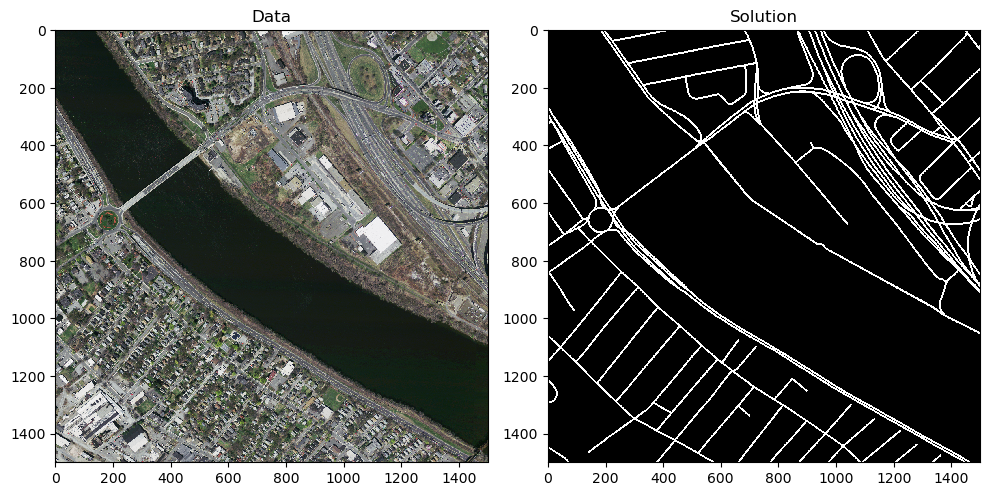

In [2]:
# Read the data
rgb = skio.imread("../../data/MA_roads/tiff/train/10828735_15.tiff")
ans = skio.imread("../../data/MA_roads/tiff/train_labels/10828735_15.tif") > 0

rgb_test = skio.imread("../../data/MA_roads/tiff/train/21929005_15.tiff")
ans_test = skio.imread("../../data/MA_roads/tiff/train_labels/21929005_15.tif") > 0

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Solution");

In [23]:
# Function to compute DICE
smooth=1
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
        
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred, labels=(True, False))

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # Recall
    recall = (C[0,0])/(C[0,0] + C[1,0])
    
    # Precision
    prec = (C[0,0])/(C[0,0] + C[0,1])

    # DICE
    dice = dice_coef(y_true, y_pred)


    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nPrecision:", np.round(recall, 3),
            "\nRecall", np.round(prec, 3), "\nDICE:", np.round(dice, 3))

# Function to create input layer
def classify_gray(image):

    # Compute the standard deviation of the r, g, and b channels
    std_dev = np.std(image, axis = 2)

    # Define a threshold for classifying gray pixels
    diff_threshold = 6 # Adjust as needed

    # Classify pixels as gray or not gray based on the standard deviation
    gray_mask = std_dev < diff_threshold
        
    return gray_mask
    
# Function to compute layers for additional model features
def compute_features(img, include_categorical = True):    
    # Range of values (gray pixels will have low range)
    r = img.max(axis = 2) - img.min(axis = 2)

    if include_categorical:
        
        # Canny edge detection
        canny_edges_r = feature.canny(img[:,:,0], sigma=4)
        canny_edges_g = feature.canny(img[:,:,1], sigma=4)
        canny_edges_b = feature.canny(img[:,:,2], sigma=4)

         # Calculation Canny gradient
        image_gray = rgb2gray(img)
        canny_edges = feature.canny(image_gray, sigma=3)
    
        # Create disk
        disk = skm.disk(1)
    
        # Area closing for hough lines
        closed_edges = skm.dilation(canny_edges, footprint = disk)
        closed_edges = closed_edges * 255
    
        lines = transform.probabilistic_hough_line(closed_edges, threshold=5, line_length=25, line_gap=3)
        hough_lines = np.zeros(image_gray.shape, dtype=np.uint8)
    
        # Draw the detected lines on the canvas
        for line in lines:
            p0, p1 = line
            # Draw line segment
            rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
            hough_lines[rr, cc] = 255  # Set the pixel values to white (255) along the line
    
        #create gray mask
        gray_mask = classify_gray(img)
        gray_mask = gray_mask.reshape((img.shape[0], img.shape[1]))
    

        img = np.dstack([img, canny_edges_r, canny_edges_g, canny_edges_b, gray_mask, hough_lines])
        
    
    # Gaussian blur sigma = 1
    gaus_r_1 = gaussian_filter(img[:,:,0], sigma = 1)
    gaus_g_1 = gaussian_filter(img[:,:,1], sigma = 1)
    gaus_b_1 = gaussian_filter(img[:,:,2], sigma = 1)
    
    # Gaussian blur sigma = 3
    gaus_r_3 = gaussian_filter(img[:,:,0], sigma = 3)
    gaus_g_3 = gaussian_filter(img[:,:,1], sigma = 3)
    gaus_b_3 = gaussian_filter(img[:,:,2], sigma = 3)

    # Gaussian blur sigma = 5
    gaus_r_5 = gaussian_filter(img[:,:,0], sigma = 5)
    gaus_g_5 = gaussian_filter(img[:,:,1], sigma = 5)
    gaus_b_5 = gaussian_filter(img[:,:,2], sigma = 5)
    
    # LoG blur sigma = .5
    log_r_5 = gaussian_laplace(img[:,:,0], sigma = .5)
    log_g_5 = gaussian_laplace(img[:,:,1], sigma = .5)
    log_b_5 = gaussian_laplace(img[:,:,2], sigma = .5)
    
    # LoG blur sigma = .6
    log_r_6 = gaussian_laplace(img[:,:,0], sigma = .6)
    log_g_6 = gaussian_laplace(img[:,:,1], sigma = .6)
    log_b_6 = gaussian_laplace(img[:,:,2], sigma = .6)
    
    # LoG blur sigma = .8
    log_r_8 = gaussian_laplace(img[:,:,0], sigma = .8)
    log_g_8 = gaussian_laplace(img[:,:,1], sigma = .8)
    log_b_8 = gaussian_laplace(img[:,:,2], sigma = .8)
    
    # Add layers to model
    return np.dstack([img, r,
                     gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                     gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                     log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8])

# Create Training and Testing Subsets

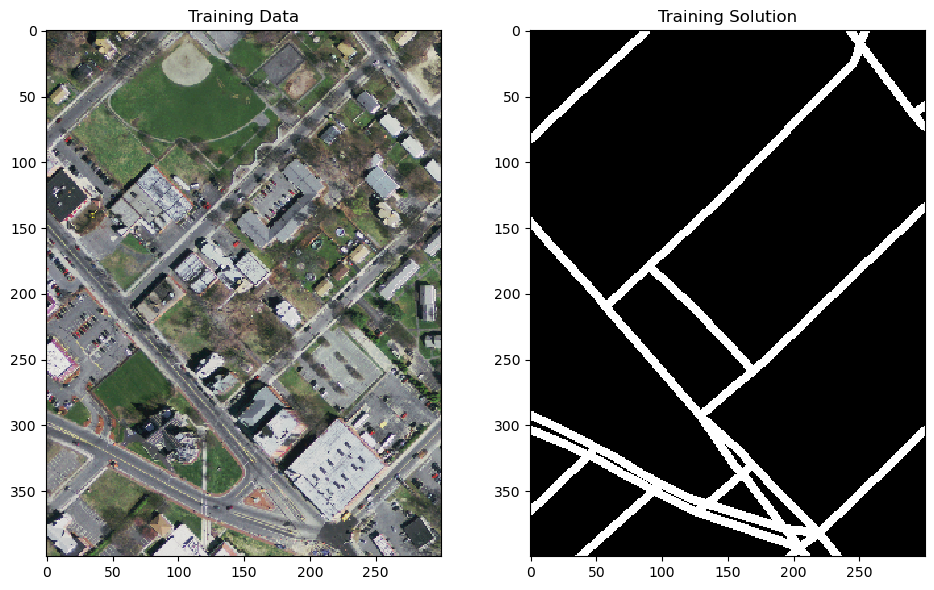

In [5]:
# Create training subset of data
# It takes too much computing power to run the model on the whole image on our own machines
small_rgb = rgb[0:400, 1200:, :]
small_ans = ans[0:400, 1200:]
# small_rgb = rgb
# small_ans = ans

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb, ax = ax[0])
ax[0].set_title("Training Data")
skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Training Solution");

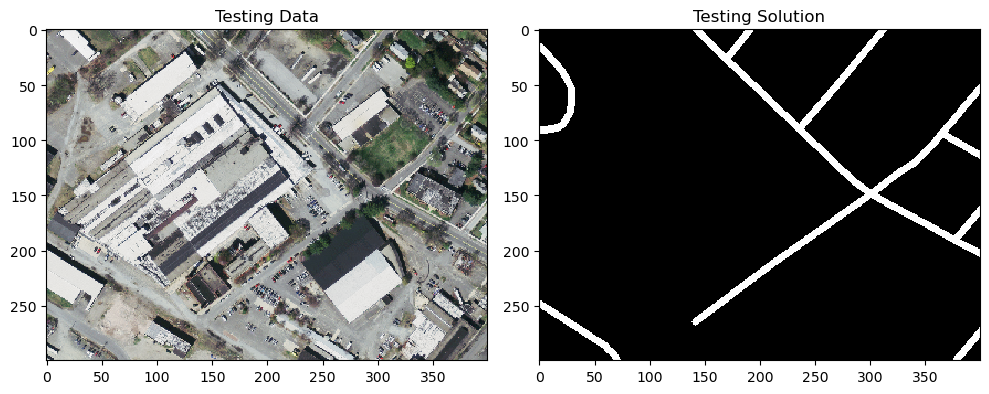

In [6]:
# Create testing subset of data
# It takes too much computing power to run the model on the whole image on our own machines
small_rgb_test = rgb[1200:, 0:400, :]
small_ans_test = ans[1200:, 0:400]
# small_rgb_test = rgb_test
# small_ans_test = ans_test

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb_test, ax = ax[0])
ax[0].set_title("Testing Data")
skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Testing Solution");

# Random Forest Model: RGB
## Train model

In [7]:
# Flatten images
train_small_rgb = small_rgb.reshape(small_rgb.shape[0]*small_rgb.shape[1], 3)
y_train = small_ans.reshape(small_ans.shape[0]*small_ans.shape[1])

In [8]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model1 = RF.fit(train_small_rgb, y_train)

In [9]:
# Predictions on training data
model1_pred = model1.predict(train_small_rgb)

# Confusion matrix
accuracy_metrics(y_train, model1_pred)

Confusion matrix:
 [[  9005   4018]
 [  1558 105419]]
Overall accuracy: 0.954 
Precision: 0.853 
Recall 0.691 
DICE: 0.764


While we have a really good overall accuracy rate, we are correctly predicting only 68.7% of the actual road pixels.
With a precision of 0.854, about 85.4% of our road predictions are actually roads.

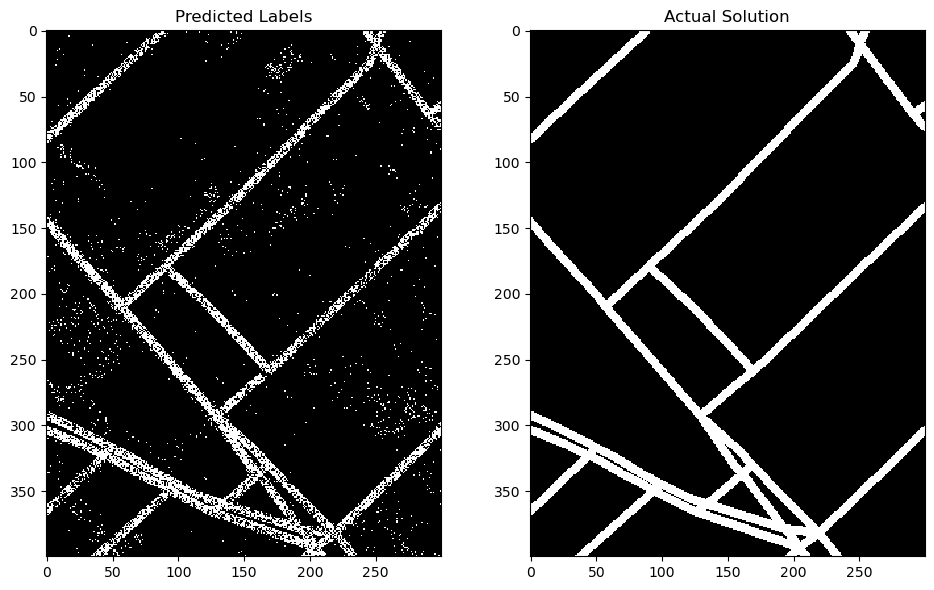

In [10]:
# Convert predictions to image
train_preds = model1_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution");

Visually, our solution looks alright, but it obviously has room for improvement.
Let's see what our results look like on the testing data.

## Test model

In [11]:
# Flatten images
test_small_rgb = small_rgb_test.reshape(small_rgb_test.shape[0]*small_rgb_test.shape[1], 3)
y_test = small_ans_test.reshape(small_ans_test.shape[0]*small_ans_test.shape[1])

In [12]:
# Predictions on testing data
model1_test_pred = model1.predict(test_small_rgb)

# Confusion matrix
accuracy_metrics(y_test, model1_test_pred)

Confusion matrix:
 [[   601   6502]
 [  4818 108079]]
Overall accuracy: 0.906 
Precision: 0.111 
Recall 0.085 
DICE: 0.096


While we still have a good overall accuracy rate, our predictions of roads is substantially worse.
We have only classified 8.3% of the road pixels correctly, and only 11.3% of our road predictions were actually roads.

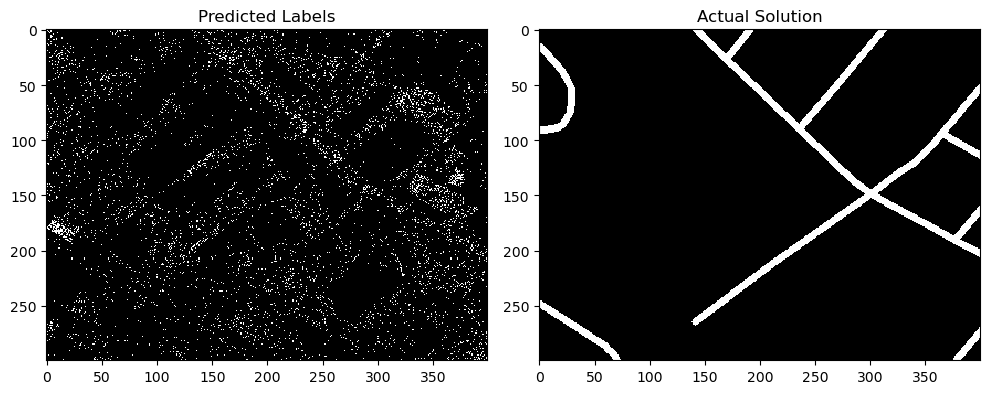

In [13]:
# Convert predictions to image
test_preds = model1_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution");

Our model did NOT generalize well! This looks terrible!

# Incorporating Additional Layers

## Create Features

Near the beginning of this notebook, we wrote a function to calculate a number of features that may help with road identification.
Here, we call our function and inspect some of those layers.

In [24]:
# Create features
small_rgb_layers = compute_features(small_rgb)

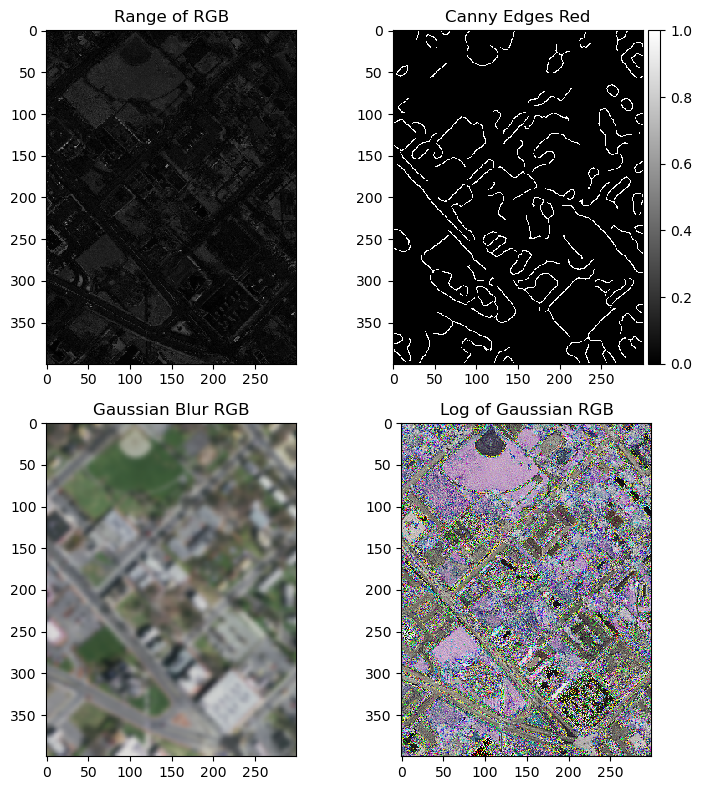

In [27]:
# Inspect features
fig, ax = plt.subplots(2, 2, figsize = (8, 8))
skio.imshow(small_rgb_layers[:,:,8], ax = ax[0,0])
ax[0,0].set_title("Range of RGB")
skio.imshow(small_rgb_layers[:,:,3], cmap = "gray", ax = ax[0,1])
ax[0,1].set_title("Canny Edges Red")
skio.imshow(small_rgb_layers[:,:,12:15], ax = ax[1,0])
ax[1,0].set_title("Gaussian Blur RGB")
skio.imshow(small_rgb_layers[:,:,18:21], ax = ax[1,1])
ax[1,1].set_title("Log of Gaussian RGB");

On the top left is the range of red, green and blue for each pixel.
We chose this feature because roads are gray, and in the RGB color space, gray pixels have similar values of red, green and blue.

On the top right is canny edges for the red channel.
We created this feature hoping to detect the edges of roads, but as you can see, it detects edges in many objects other than roads.
We include canny edges in the red, green and blue channels.

On the bottom left is the original image after gaussian blurring with $\sigma = 3$.
Our thought process here was that there might be some noise in the image leading random pixels to have the same R, G, and B values as roads.
By blurring the image, we hoped to account for this by giving some weight to the values of nearby pixels.
We include gaussian blur with $\sigma = 1$, $\sigma = 3$, and $\sigma = 5$ for red, green and blue, hoping that our model might learn from multiple blurring radii.

On the bottom right is our image after the log of gaussian filter has been applied to the red, green and blue channels.
We hopes to pick up on the width/frequency of roads with this filter, so we included this filter for $\sigma = 0.5$, $\sigma = 0.6$, and $\sigma = 0.8$.

## Train Model

In [31]:
# Train model

# Flatten image
train_small_rgb_layers = small_rgb_layers.reshape(small_rgb_layers.shape[0]*small_rgb_layers.shape[1], small_rgb_layers.shape[2])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model2 = RF.fit(train_small_rgb_layers, y_train)

# Predictions on training data
model2_pred = model2.predict(train_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_train, model2_pred)

Confusion matrix:
 [[ 13022      1]
 [     0 106977]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Before adding the additional layers to our training data, our overall accuracy was 0.954, precision was 0.854, and recall was 0.69 on our training data.
Now we have virtually perfect results!
Let's look at an image of the output.

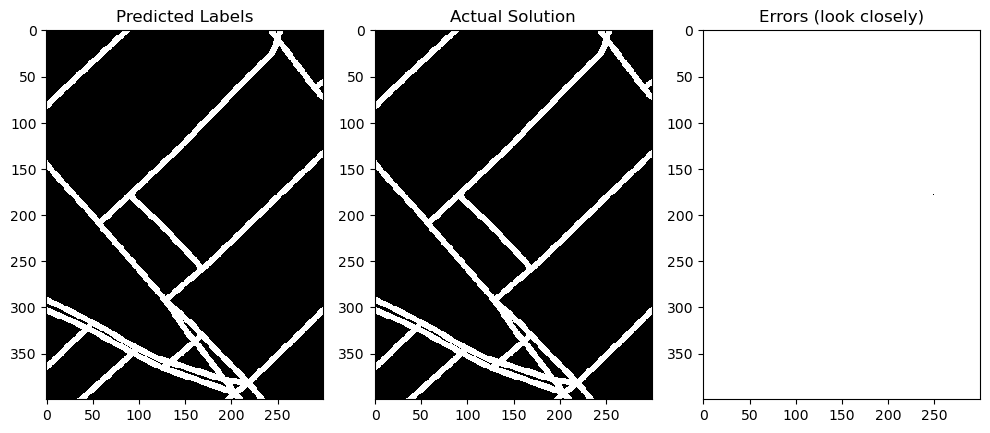

In [32]:
# Convert predictions to image
train_preds = model2_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(train_preds==small_ans, ax = ax[2])
ax[2].set_title("Errors (look closely)");

Yep, can't even find the errors without looking closely at the difference between the two images.
Let's evaluate our results on the testing data!

## Test Model

In [33]:
# Create additional features
small_rgb_test_layers = compute_features(small_rgb_test)

In [36]:
# Flatten image
test_small_rgb_layers = small_rgb_test_layers.reshape(small_rgb_test_layers.shape[0]*small_rgb_test_layers.shape[1], small_rgb_layers.shape[2])

# Predictions on testing data
model2_test_pred = model2.predict(test_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_test, model2_test_pred)

Confusion matrix:
 [[   341   6762]
 [  1865 111032]]
Overall accuracy: 0.928 
Precision: 0.155 
Recall 0.048 
DICE: 0.073


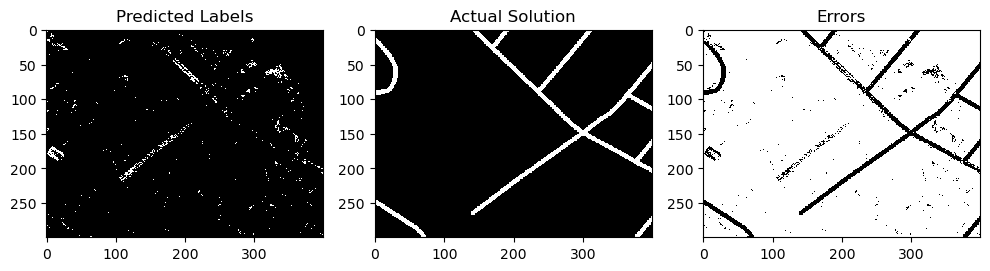

In [37]:
# Convert predictions to image
test_preds = model2_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0], cmap = "gray")
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(test_preds==small_ans_test, ax = ax[2])
ax[2].set_title("Errors");

Adding these filters to our model had negligible impact on our results.
It improved the accuracy from 0.906 to 0.927 and the precision from 0.113 to 0.147, but the recall dropped from 0.086 to 0.047.
This means that of the pixels that actually represent roads, we are only correctly classifying 4.7% of them.
With perfect results on our training data and pitiful results on our testing data, it appears that incorporating these features in our training data led to severe overfitting!

# Sampling for Overfitting

We have fed a substantial amount of data, which ought to contain some useful information regarding roads, to our model
In our training solution, this data was in fact useful, leading to virtually 100% accuracy.
However, on the testing data for both the RGB model and the model with additional layers, our model correctly predicted less than 10% of our roads.
Perhaps this means that our model is overfit to our training data.
Since the vast majority of pixels in our training data represent non-roads, perhaps our model is overfit to the particularities of the non-road pixels in our training data.
One way to address this issue is to randomly select an equal number of pixels of both classes, and then train the model on those pixels.
Let's try randomly picking 5000 road pixels and 5000 non-road pixels for our training data and 5000 of each for our testing data and evaluating our model's performance.

## Train RGB Model

First, let's use this method on a model with just RGB layers.

In [38]:
# Flatten training images
train_rgb = rgb.reshape(rgb.shape[0]*rgb.shape[1], 3)
y_train = ans.reshape(ans.shape[0]*ans.shape[1])

# Subset training data by label
y_train_true = y_train[y_train]
y_train_false = y_train[~y_train]
train_rgb_true = train_rgb[y_train]
train_rgb_false = train_rgb[~y_train]

# Sample indices of each label
true_indices = sample_without_replacement(y_train_true.shape[0], 10000)
false_indices = sample_without_replacement(y_train_false.shape[0], 10000)

# Create modified training data
y_train_mod = np.concatenate([y_train_true[true_indices[:5000]], y_train_false[false_indices[:5000]]])
train_rgb_mod = np.concatenate([train_rgb_true[true_indices[:5000]], train_rgb_false[false_indices[:5000]]])

# Create modified testing data
y_test_mod = np.concatenate([y_train_true[true_indices[5000:]], y_train_false[false_indices[5000:]]])
test_rgb_mod = np.concatenate([train_rgb_true[true_indices[5000:]], train_rgb_false[false_indices[5000:]]])

In [39]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model3 = RF.fit(train_rgb_mod, y_train_mod)

# Predictions on training data
model3_pred = model3.predict(train_rgb_mod)

# Confusion matrix
accuracy_metrics(y_train_mod, model3_pred)

Confusion matrix:
 [[4962   38]
 [  86 4914]]
Overall accuracy: 0.988 
Precision: 0.983 
Recall 0.992 
DICE: 0.988


While this model does not have 100% training accuracy like the additional layers model, it has improved significantly over the original RGB model.
Most notably, the training recall has improved from less than 70% to roughly 99%.
Let's see if we maintain this performance when we make predictions on our testing data.

## Test RGB Model

In [40]:
# Predictions on testing data
model3_test_pred = model3.predict(test_rgb_mod)

# Confusion matrix
accuracy_metrics(y_test_mod, model3_test_pred)

Confusion matrix:
 [[3810 1190]
 [1332 3668]]
Overall accuracy: 0.748 
Precision: 0.741 
Recall 0.762 
DICE: 0.751


Our results are encouraging!
Our overall accuracy, precision, and recall are all approximatly 0.75.
In the original RGB model, the overall accuracy was over 90%, while the precision and recall were roughly 10%.
By balancing the amount of training data in each class, we were able to balance the different accuracy metrics, improving our predictions of roads at the expense of our predictions of non-roads.
Perhaps if we incorporate our additional layers into the model, these balance improvements will translate to balanced and higher accuracy metrics. 

## Test RGB Model on New Image

While our results above are encouraging, our training and testing data were both drawn from the same image, so our model may have overtrained to this image.
Let's form predictions and compute accuracy metrics on a different image.

In [41]:
# Flatten testing images
flat_rgb_test = rgb_test.reshape(rgb_test.shape[0]*rgb_test.shape[1], 3)
y_test = ans_test.reshape(ans_test.shape[0]*ans_test.shape[1])

# Predictions on testing data
model3_test_pred_2 = model3.predict(flat_rgb_test)

# Confusion matrix
accuracy_metrics(y_test, model3_test_pred_2)

Confusion matrix:
 [[  98370   41895]
 [ 342878 1766857]]
Overall accuracy: 0.829 
Precision: 0.223 
Recall 0.701 
DICE: 0.338


Surprisingly, the overall accuracy is higher in the testing image than in the training image!
The recall is still over 70%, indicating that we are capturing most pixels representing roads correctly.
With a much lower precision, we must be predicting road pixels frequently where there are not actually roads.

Since we are working with an entire image, we can inspect our results!

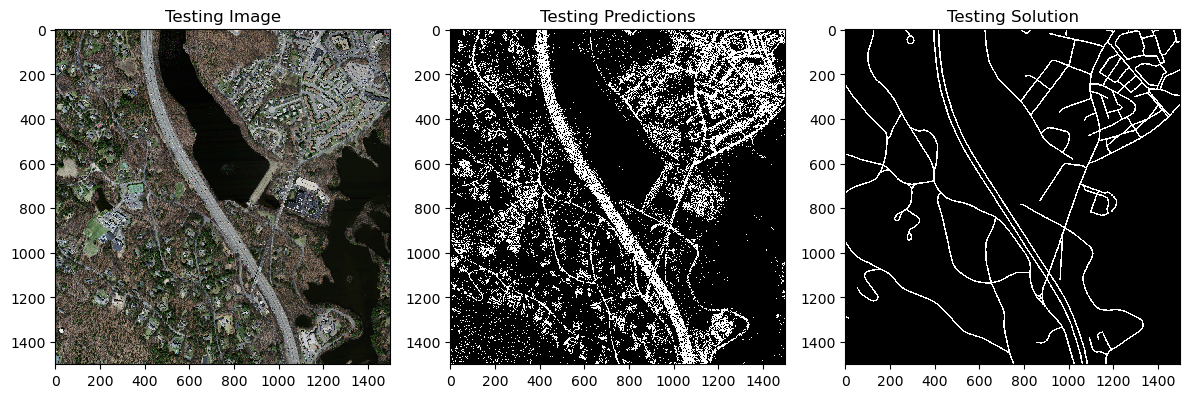

In [42]:
# Convert predictions to image
test_preds = model3_test_pred_2.reshape(rgb_test.shape[0], rgb_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

It looks like we tend to label pixels as roads when they in reality represent other human features like buildings.
We also exaggerate the width of some roads

## Train Additional Layers Model

In [43]:
# Create additional features
train_rgb_mod_layers = compute_features(rgb)

# Flatten training image with extra layers
train_rgb_2 = train_rgb_mod_layers.reshape(train_rgb_mod_layers.shape[0]*train_rgb_mod_layers.shape[1], train_rgb_mod_layers.shape[2])

# Subset training data by label
train_rgb_true_2 = train_rgb_2[y_train]
train_rgb_false_2 = train_rgb_2[~y_train]

# Create modified training data
train_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[:5000]], train_rgb_false_2[false_indices[:5000]]])

# Create modified testing data
test_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[5000:]], train_rgb_false_2[false_indices[5000:]]])

In [44]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model4 = RF.fit(train_rgb_mod_2, y_train_mod)

# Predictions on training data
model4_pred = model4.predict(train_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_train_mod, model4_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Our training results are literally perfect.
Does this translate to our testing data?

## Test Additional Layers Model

In [45]:
# Predictions on testing data
model4_test_pred = model4.predict(test_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_test_mod, model4_test_pred)

Confusion matrix:
 [[4178  822]
 [1133 3867]]
Overall accuracy: 0.804 
Precision: 0.787 
Recall 0.836 
DICE: 0.81


It appears that there were some errors on our testing data.
Going from the RGB model to the additional layers model, our overall accuracy improved from 0.755 to 0.812, the precision improved from 0.749 to 0.796, and the recall improved from 0.767 to 0.84.
These are the most accurate road predictions yet!

While our training and testing data contained none of the same pixels, they were both drawn from the same image, so it is possible that they were overtrained to our particular image of choice.
Perhaps a more valid testing metric would involve testing our model on pixels from a different image.
Let's form predictions and compute accuracy metrics on the entirety of another image.

## Test Additional Layers Model on New Image

In [46]:
# Create additional features
test_rgb_layers_3 = compute_features(rgb_test)

# Flatten testing images
test_rgb_3 = test_rgb_layers_3.reshape(test_rgb_layers_3.shape[0]*test_rgb_layers_3.shape[1], test_rgb_layers_3.shape[2])

In [47]:
# Predictions on testing data
model4_test_pred_2 = model4.predict(test_rgb_3)

# Confusion matrix
accuracy_metrics(y_test, model4_test_pred_2)

Confusion matrix:
 [[  91162   49103]
 [ 253648 1856087]]
Overall accuracy: 0.865 
Precision: 0.264 
Recall 0.65 
DICE: 0.376


Similar to the RGB model, the results on the testing image were largely similar to the results on the previous image, except for the precision dropping by over 50%
The overall accuracy is over 85%, but the recall is now 65.9% and the precision is now 26.6%.
While this is certainly not perfect, the precision and recall are still a substantial improvement over the models without sampling.
However, the recall was actually slightly higher in the sampled RGB model, indicating that the RGB model generalized better in terms of predicting road pixels.
Perhaps there are tactics we can use to combat overfitting.

Also, since we are now working with a complete image, we can once again inspect a full image illustrating our predictions versus the truth.

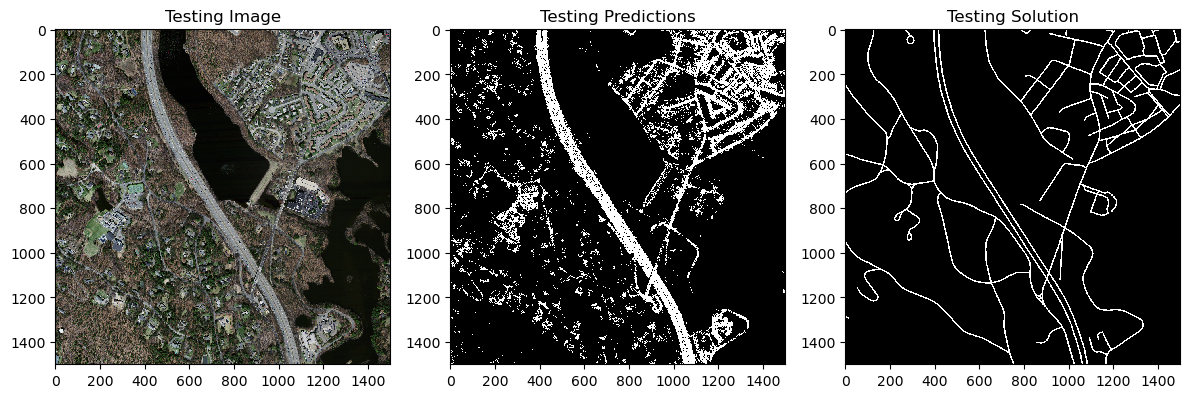

In [48]:
# Convert predictions to image
test_preds = model4_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

Once again, our model tends to incorrectly predict roads where there are other human features like buildings, and it exaggerates the width of some roads.

# PCA for Overfitting

It appears that our additional layers model with sampled training data is overfit to our training data, as we have excellent performance on the training data but subpar performance on the new image.
Perhaps our model suffers from overfitting because we have constructed so many features, many of which are similar to one another.
To help combat this issue, we fit our model again below, but after applying Principal Component Analysis and selecting the most important components.

## Train Model

First, we apply Principal Component Analysis to our training data and plot the percent variance explained by each component.
Note that PCA is only applicable for continuous features, so we cannot include binary features such as canny edges in this model.

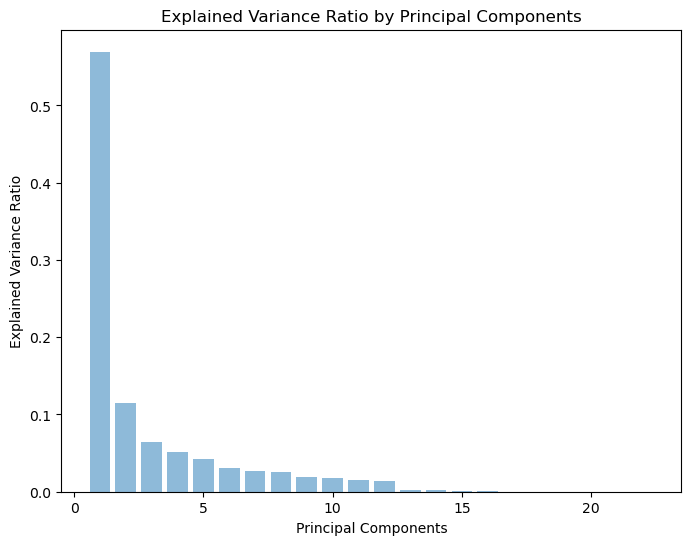

In [49]:
# Add layers to model
train_pca_layers = compute_features(rgb, include_categorical = False)   

# Flatten training image with extra layers
train_pca_layers_flat = train_pca_layers.reshape(train_pca_layers.shape[0]*train_pca_layers.shape[1], train_pca_layers.shape[2])

# Standardize the features
scaler = StandardScaler()
train_pca_layers_scaled = scaler.fit_transform(train_pca_layers_flat)

# Initialize PCA and fit the scaled data
pca = PCA(n_components=train_pca_layers.shape[2])
layers_pca = pca.fit_transform(train_pca_layers_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

Apparently, over 50% of the variance in our data can be explained by the first component!
The second component only accounts for about 11.5% of the variance in the data, and the numbers continue to drop after that.

In [50]:
explained_variance_ratio[0:5].sum()

0.843420909342875

Apparently, the first 5 components account for over 84% of the variation in our data.
Let's try only retaining the first 5 components for our model and seeing whether our performance improves.

In [51]:
# Initialize PCA and fit the scaled data
pca = PCA(n_components=5)
layers_pca = pca.fit_transform(train_pca_layers_scaled)

# Subset training data by label
layers_pca_true = layers_pca[y_train]
layers_pca_false = layers_pca[~y_train]

# Create modified training data
layers_pca_mod_train = np.concatenate([layers_pca_true[true_indices[:5000]], layers_pca_false[false_indices[:5000]]])

# Create modified testing data
layers_pca_mod_test = np.concatenate([layers_pca_true[true_indices[5000:]], layers_pca_false[false_indices[5000:]]])

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model5 = RF.fit(layers_pca_mod_train, y_train_mod)

# Predictions on training data
model5_pred = model5.predict(layers_pca_mod_train)

# Confusion matrix
accuracy_metrics(y_train_mod, model5_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Per usual, our model's performance is perfect on the training data.

## Test Model

In [52]:
# Predictions on testing data
model5_test_pred = model5.predict(layers_pca_mod_test)

# Confusion matrix
accuracy_metrics(y_test_mod, model5_test_pred)

Confusion matrix:
 [[3946 1054]
 [1477 3523]]
Overall accuracy: 0.747 
Precision: 0.728 
Recall 0.789 
DICE: 0.757


On the testing data, all of our model's performance metrics are lower than its non-PCA counterpart, although not by that much.

## Test Model on New Image

In [53]:
# Add layers to model
test_pca_layers = compute_features(rgb_test, include_categorical = False)

# Flatten testing images
test_pca_layers_flat = test_pca_layers.reshape(test_pca_layers.shape[0]*test_pca_layers.shape[1], 22)

# Standardize the features
test_pca_layers_scaled = scaler.fit_transform(test_pca_layers_flat)

# Project onto principal components
layers_pca_test = pca.transform(test_pca_layers_scaled)

In [54]:
# Predictions on testing data
model5_test_pred_2 = model5.predict(layers_pca_test)

# Confusion matrix
accuracy_metrics(y_test, model5_test_pred_2)

Confusion matrix:
 [[  69301   70964]
 [ 511205 1598530]]
Overall accuracy: 0.741 
Precision: 0.119 
Recall 0.494 
DICE: 0.192


Again, on the testing image, all of our model's performance metrics are lower than its non-PCA counterpart.
In this scenario, it appears that the components explaining very little variation in the data were actually somewhat useful for predictions.
Note that we tried this with a variety of number of retained components, and we found that the model's performance improved as we increased the number of components.

Below, we inspect the image of our predictions.

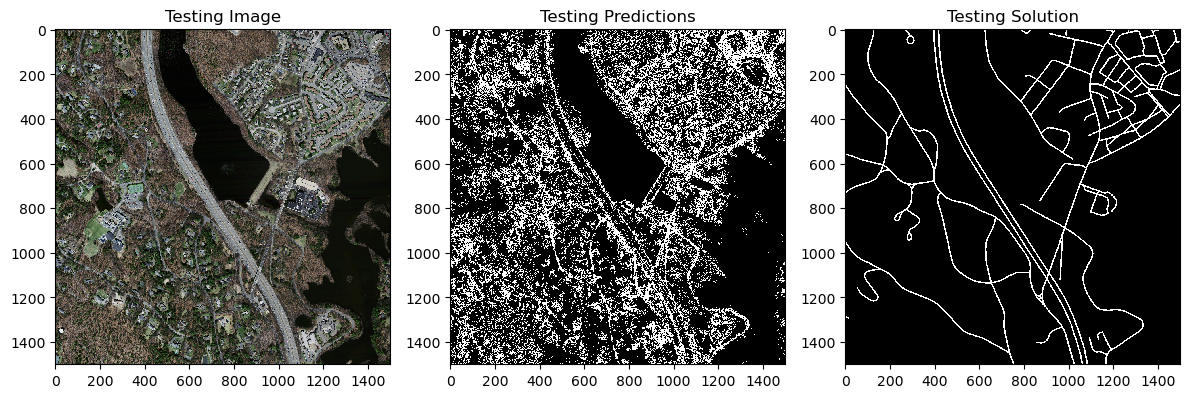

In [55]:
# Convert predictions to image
test_preds = model5_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

Visually, our predictions appear somewhat worse that those from our non-PCA additional layers model.
There is overall a lot more noise in our predictions, and interestingly, we are not predicting a road in much of the massive highway.

# Sampling From Multiple Images

## Training Sample RGB

In [56]:
# Store id's of images
imgs = ["10828735_15", "10228675_15", "10228705_15", "10228720_15", "10228735_15", "10528675_15", "10528750_15", "10978720_15", "11128825_15", "12028750_15"]

# Initialize arrays to store training data
y_train = np.array([])
rgb_train = np.zeros((0,3))

# Sample from each image
for img in imgs:
    rgb = skio.imread("../../data/MA_roads/tiff/train/" + img + ".tiff")
    ans = skio.imread("../../data/MA_roads/tiff/train_labels/" + img + ".tif") > 0
    
    # Flatten training images
    rgb_flat = rgb.reshape(rgb.shape[0]*rgb.shape[1], 3)
    ans_flat = ans.reshape(ans.shape[0]*ans.shape[1])
    
    # Subset training data by label
    ans_true = ans_flat[ans_flat]
    ans_false = ans_flat[~ans_flat]
    rgb_true = rgb_flat[ans_flat]
    rgb_false = rgb_flat[~ans_flat]
    
    # Sample indices of each label
    true_indices = sample_without_replacement(ans_true.shape[0], 5000)
    false_indices = sample_without_replacement(ans_false.shape[0], 5000)
    
    # Create modified training data
    y_train = np.concatenate([y_train, ans_true[true_indices], ans_false[false_indices]])
    rgb_train = np.concatenate([rgb_train, rgb_true[true_indices], rgb_false[false_indices]])

## Train RGB Model

In [57]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model6 = RF.fit(rgb_train, y_train)

# Predictions on training data
model6_pred = model6.predict(rgb_train)

# Confusion matrix
accuracy_metrics(y_train, model6_pred)

Confusion matrix:
 [[48147  1853]
 [ 2687 47313]]
Overall accuracy: 0.955 
Precision: 0.947 
Recall 0.963 
DICE: 0.955


## Test RGB Model on New Image

In [58]:
# Predictions on testing data
model6_test_pred = model6.predict(flat_rgb_test)

# Confusion matrix
accuracy_metrics(y_test, model6_test_pred)

Confusion matrix:
 [[ 109933   30332]
 [ 377915 1731820]]
Overall accuracy: 0.819 
Precision: 0.225 
Recall 0.784 
DICE: 0.35


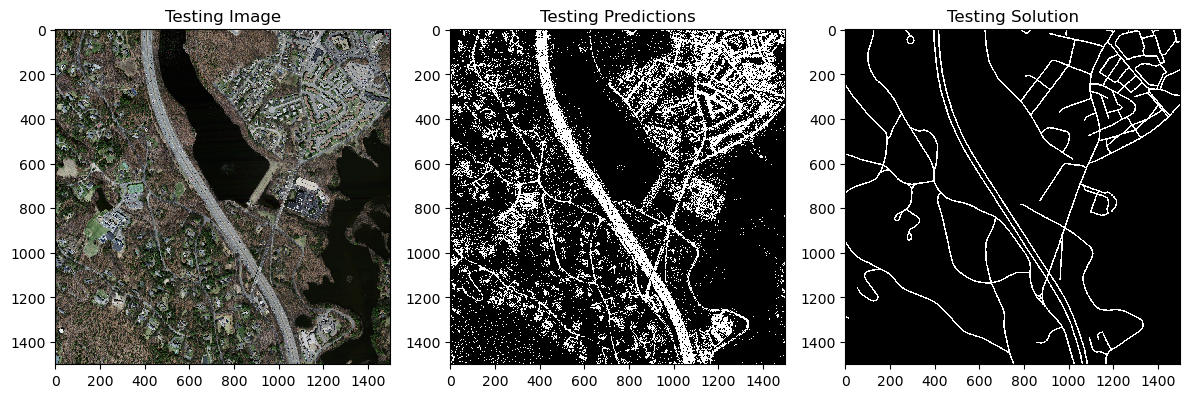

In [59]:
# Convert predictions to image
test_preds = model6_test_pred.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

## Training Sample Additional Layers

In [61]:
# Store id's of images
imgs = ["10828735_15", "10228675_15", "10228705_15", "10228720_15", "10228735_15", "10528675_15", "10528750_15", "10978720_15", "11128825_15", "12028750_15"]

# Initialize arrays to store training data
y_train = np.array([])
rgb_train = np.zeros((0,27))

# Sample from each image
for img in imgs:
    rgb = skio.imread("../../data/MA_roads/tiff/train/" + img + ".tiff")
    ans = skio.imread("../../data/MA_roads/tiff/train_labels/" + img + ".tif") > 0

    # Create additional layers
    rgb_layers = compute_features(rgb)
    
    # Flatten training images
    rgb_flat = rgb_layers.reshape(rgb_layers.shape[0]*rgb_layers.shape[1], rgb_layers.shape[2])
    ans_flat = ans.reshape(ans.shape[0]*ans.shape[1])
    
    # Subset training data by label
    ans_true = ans_flat[ans_flat]
    ans_false = ans_flat[~ans_flat]
    rgb_true = rgb_flat[ans_flat]
    rgb_false = rgb_flat[~ans_flat]
    
    # Sample indices of each label
    true_indices = sample_without_replacement(ans_true.shape[0], 5000)
    false_indices = sample_without_replacement(ans_false.shape[0], 5000)
    
    # Create modified training data
    y_train = np.concatenate([y_train, ans_true[true_indices], ans_false[false_indices]])
    rgb_train = np.concatenate([rgb_train, rgb_true[true_indices], rgb_false[false_indices]])

## Train Additional Layers Model

In [62]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model7 = RF.fit(rgb_train, y_train)

# Predictions on training data
model7_pred = model7.predict(rgb_train)

# Confusion matrix
accuracy_metrics(y_train, model7_pred)

Confusion matrix:
 [[49998     2]
 [    1 49999]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


## Test Additional Layers Model on New Image

In [63]:
# Predictions on testing data
model7_test_pred = model7.predict(test_rgb_3)

# Confusion matrix
accuracy_metrics(y_test, model7_test_pred)

Confusion matrix:
 [[ 115326   24939]
 [ 322235 1787500]]
Overall accuracy: 0.846 
Precision: 0.264 
Recall 0.822 
DICE: 0.399


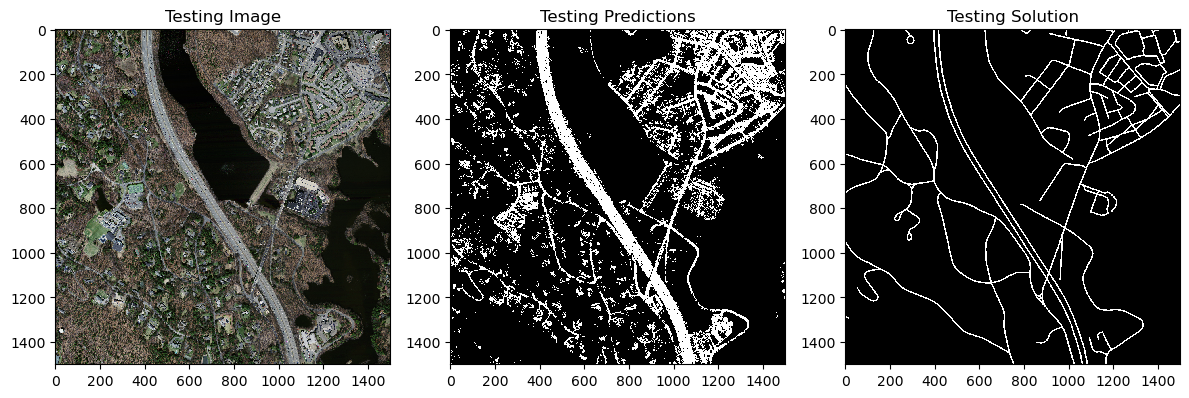

In [64]:
# Convert predictions to image
test_preds = model7_test_pred.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");